## Скачиваем необходимое

Сначала нужно средствами NLTK загрузить WordNet.



In [1]:
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Готовим данные к работе

Затем импортируем данные из подготовленного текстового файла. Файл содержит набор пар слов (только имён существительных), для которых известны экспертные оценки сходства.

Строим ассоциативный массив "пара слов -- оценка близости".

In [2]:
with open("wordsim_similarity_goldstandard.txt", encoding="utf-8") as rf:
    triples = [line.strip().split("\t") for line in rf.readlines()]
    score_map = {tuple(triple[:2]): float(triple[2]) for triple in triples}

Отметим, что из исходного набора данных мы взяли только экспертные оценки сходства (similarity) и только для существительных. Исходный набор данных доступен по [ссылке](http://alfonseca.org/pubs/ws353simrel.tar.gz)

Посмотрим на примеры оценок.

У слов может быть по несколько значений, которые различаются в WordNet. Здесь -- ради примера -- мы будем "жадно" выбирать первое попавшееся, но далее будем работать с ними иначе.




In [3]:
for w_1, w_2 in list(score_map)[:2]:
    print("\nWords: %s-%s\nGround truth score: %.2f" % (w_1, w_2, score_map[(w_1, w_2)]))

    ss_1 = wn.synset(w_1 + ".n.01")
    ss_2 = wn.synset(w_2 + ".n.01")

    print("\nPath: %.3f" % ss_1.path_similarity(ss_2), end=" ")
    print("\nwup: %.3f" % ss_1.wup_similarity(ss_2), end=" ")
    print("\nshortest_path: %.3f" % ss_1.shortest_path_distance(ss_2))


Words: tiger-cat
Ground truth score: 7.35

Path: 0.091 
wup: 0.545 
shortest_path: 10.000

Words: tiger-tiger
Ground truth score: 10.00

Path: 1.000 
wup: 0.750 
shortest_path: 0.000


Вычисляем для всех пар несколько оценок

In [4]:
from itertools import product

list_pairs = list(score_map)
wup_list, true_list, path_list = [], [], []

# Для всех пар
for w_1, w_2 in list_pairs:

    try:
        all_w_1 = wn.synsets(w_1, pos="n")
        all_w_2 = wn.synsets(w_2, pos="n")

        # Добавляем интересующие нас метрики и экспертные оценки
        wup = max([item1.wup_similarity(item2) \
                    for item1, item2 in product(all_w_1, all_w_2)])
        wup_list.append(wup)

        path = max([item1.path_similarity(item2) \
                    for item1, item2 in product(all_w_1, all_w_2)])
        path_list.append(path)

        true_list.append(score_map[(w_1, w_2)])

    except Exception as e:
        print(w_1, w_2, "error:", e)

drink eat error: max() arg is an empty sequence
stock live error: max() arg is an empty sequence


## Вычисляем ранговую корреляцию Спирмена

In [5]:
from scipy.stats import spearmanr

coef, p = spearmanr(wup_list, true_list)
print("wup    Spearman R: %.4f" % coef)

coef, p = spearmanr(path_list, true_list)
print("path Spearman R: %.4f" % coef)

wup    Spearman R: 0.6438
path Spearman R: 0.6176


# Индивидуальное задание

По [ссылке](https://courses.openedu.ru/assets/courseware/v1/a6f9fc5c76dbb8d2efd33bd0e1240208/asset-v1:ITMOUniversity+AUTXTIMGPROC+spring_2024_ITMO_mag+type@asset+block/Task_4_sample_9.csv) представлена выборка из датасета WordSim353. Ваша задача, используя тезаурус WordNet, вычислить оценки близости для всех элементов соответствующих синсетов представленных пар слов. В качестве близости двух слов использовать наибольшую близость среди соответствующих элементов рассматриваемых синсетов. В качестве меры близости использовать: близость на основе пути (`path_similarity`), меру Leacock-Chodorow (`lch_similarity`) и меру Wu-Palmer (`wup_similarity`). Вычислить коэффициент ранговой корреляции Спирмена для каждой меры близости, используя известную экспертную оценку (колонка `Score` в выборке).  

_Введите коэффициент ранговой корреляции Спирмена для оценок, полученных методом `path_similarity` и известных экспертных оценок. Десятичный разделитель точка. Ответ округлите до тысячных:_
```
0.614
```
_Введите коэффициент ранговой корреляции Спирмена для оценок, полученных методом `lch_similarity` и известных экспертных оценок.
Десятичный разделитель точка. Ответ округлите до тысячных:_
```
0.614
```
_Введите коэффициент ранговой корреляции Спирмена для оценок, полученных методом `wup_similarity` и известных экспертных оценок. Десятичный разделитель точка. Ответ округлите до тысячных:_
```
0.625
```
_При помощи метода `hyponyms()` найдите количество гипонимов для синсета `furnace.n.01`, а также при помощи метода `name()` найдите значение первого в гипонима из списка. Введите количество гипонимов для синсета `furnace.n.01`. Введите целое число:_
```
14
```
_Первый элемент списка гипонимов синсета `furnace.n.01`:
Введите (без кавычек) результат выполнения метода `name()`, например `bird.n.01`:_
```
athanor.n.01
```


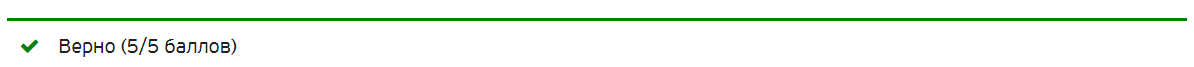

In [6]:
import pandas as pd

df = pd.read_csv("/content/Task_4_sample_9.csv")
print(df)

          word_1        word_2  Score
0          space     chemistry   4.88
1           five         month   3.38
2           word    similarity   4.75
3           king       cabbage   0.23
4          tiger     carnivore   7.08
..           ...           ...    ...
145        train           car   6.31
146       street        avenue   8.88
147  observation  architecture   4.38
148     ministry       culture   4.69
149        peace          plan   4.75

[150 rows x 3 columns]


In [7]:
path_sim_list, lch_sim_list, wup_sim_list, true_list = [], [], [], []

for index, row in df.iterrows():
    w_1, w_2 = row['word_1'], row['word_2']
    syn_1 = wn.synsets(w_1, pos='n')
    syn_2 = wn.synsets(w_2, pos='n')
    path_sim = max((s_1.path_similarity(s_2) or 0 for s_1 in syn_1 for s_2 in syn_2))
    lch_sim = max((s_1.lch_similarity(s_2) or 0 for s_1 in syn_1 for s_2 in syn_2))
    wup_sim = max((s_1.wup_similarity(s_2) or 0 for s_1 in syn_1 for s_2 in syn_2))
    path_sim_list.append(path_sim)
    lch_sim_list.append(lch_sim)
    wup_sim_list.append(wup_sim)
    true_list.append(row['Score'])

# Вычислим корреляцию Спирмена
path_corr = spearmanr(path_sim_list, true_list)[0]
lch_corr = spearmanr(lch_sim_list, true_list)[0]
wup_corr = spearmanr(wup_sim_list, true_list)[0]

# Найдем гипонимы
furnace = wn.synset('furnace.n.01')
hyponyms = furnace.hyponyms()
num_hyponyms = len(hyponyms)
first_hyponym = hyponyms[0].name()

print("Коэффициент ранговой корреляции Спирмена для path_similarity:", round(path_corr, 3))
print("Коэффициент ранговой корреляции Спирмена для lch_similarity:", round(lch_corr, 3))
print("Коэффициент ранговой корреляции Спирмена для wup_similarity:", round(wup_corr, 3))
print("Количество гипонимов для синсета furnace.n.01:", num_hyponyms)
print("Первый элемент списка гипонимов синсета furnace.n.01:", first_hyponym)

Коэффициент ранговой корреляции Спирмена для path_similarity: 0.614
Коэффициент ранговой корреляции Спирмена для lch_similarity: 0.614
Коэффициент ранговой корреляции Спирмена для wup_similarity: 0.625
Количество гипонимов для синсета furnace.n.01: 14
Первый элемент списка гипонимов синсета furnace.n.01: athanor.n.01
